In [1]:
import os
import sys
import time
import math
import numpy as np
import pandas as pd
import geopandas as gpd


input_folder = os.path.join('..', '..', '..', 'Cambodia', 'Data')
output_folder = os.path.join('..', 'input', 'Ecuador', 'Trade')

# Produce export table

In [5]:
input_folder = os.path.join('..', '..', '..', 'Ecuador', 'Data')
trade_data = pd.read_csv(os.path.join(input_folder, "Raw", "Trade", "comtrade_2016_AG4_imports_Ecuador_as_partner.csv"))

# because we chose "Cambodia as Partner", the "Trade Flow" (import/export) is to be understood from the point of view of the "Reporting Country"
# so we select 'import' as trade flow
export_data = trade_data.loc[trade_data['Trade Flow']=="Import", ['Reporter ISO', 'Commodity Code', 'Commodity', 'Trade Value (US$)']]

# groupby country region
country_grouping_modified = pd.read_csv(os.path.join(input_folder, "Structured", "Trade", "country_grouping_ecuador.csv"))
export_data = export_data.merge(country_grouping_modified[['alpha-3', "region"]], how="left", left_on="Reporter ISO", right_on="alpha-3")
export_data = export_data.groupby(['region', "Commodity Code"])['Trade Value (US$)'].sum().reset_index()

# map sectors
H3_to_Sector = pd.read_csv(os.path.join(input_folder, "Structured", "Trade", "HS17lvl4_to_59sectors.csv")).set_index('hs17_lvl4_code')['trigram']
export_data['sector'] = export_data['Commodity Code'].map(H3_to_Sector)
print("Check unmapped sectors")
print(export_data[export_data["sector"].isnull()])
print("Represents "+"{:,.2f}%".format(100*export_data.loc[export_data["sector"].isnull(), 'Trade Value (US$)'].sum()/export_data['Trade Value (US$)'].sum()))
print("Skip them")
export_data = export_data[~export_data['sector'].isnull()]

# aggregate
export_data = export_data.groupby(['region', 'sector'])['Trade Value (US$)'].sum().unstack(level=0)

# add other sectors with 0
all_sectors = pd.read_csv(os.path.join(input_folder, "Structured", "Sectors", "61sector_table.csv"))[['trigram']].set_index('trigram')
export_data = pd.concat([all_sectors, export_data], axis=1).fillna(0)

# turn into kUSD
export_data = export_data / 1000

# export
export_data.transpose().to_csv(os.path.join(output_folder, "59sector_export_table.csv"))

Check unmapped sectors
     region  Commodity Code  Trade Value (US$) sector
213     AFR            6908              72005    NaN
622     ASI            5304             435704    NaN
1041    CAR            6908             218371    NaN
1377    COL            6908             536781    NaN
1902    EUR            6908              73369    NaN
2559    NAM            6908            4991111    NaN
3170    PER            6908             214240    NaN
Represents 0.04%
Skip them


### Legacy - Cambodia

In [17]:
trade_data = pd.read_csv(os.path.join(input_folder, "Raw", "Trade", "comtrade_2015_CambodiaAsPartner_HS07_H3.csv"))

# because we chose "Cambodia as Partner", the "Trade Flow" (import/export) is to be understood from the point of view of the "Reporting Country"
export_data = trade_data.loc[trade_data['Trade Flow']=="Import", ['Reporter ISO', 'Commodity Code', 'Commodity', 'Trade Value (US$)']]

# groupby country region
country_grouping_modified = pd.read_csv(os.path.join(input_folder, "Structured", "Trade", "country_grouping_modified.csv"))
export_data = export_data.merge(country_grouping_modified[['alpha-3', "region"]], how="left", left_on="Reporter ISO", right_on="alpha-3")
export_data = export_data.groupby(['region', "Commodity Code"])['Trade Value (US$)'].sum().reset_index()

# map sectors
H3_to_Sector = pd.read_csv(os.path.join(input_folder, "Structured", "Trade", "H3_to_Sector.csv")).set_index('Commodity Code')['sector_code']
sector_to_trigram = pd.read_csv(os.path.join(input_folder, "Structured", "Sectors", "sector_trigram.csv")).set_index('id')['trigram']
export_data['sector_code'] = export_data['Commodity Code'].map(H3_to_Sector)

print("Check unmapped sectors")
print(export_data[export_data["sector_code"].isnull()])
print("Represents "+"{:,.2f}%".format(100*export_data.loc[export_data["sector_code"].isnull(), 'Trade Value (US$)'].sum()/export_data['Trade Value (US$)'].sum()))
print("Skip them")
export_data = export_data[~export_data['sector_code'].isnull()]
export_data['sector_code'] = export_data['sector_code'].astype(int)
export_data['sector'] = export_data['sector_code'].map(sector_to_trigram)
print(export_data.head())
export_data = export_data.groupby(['region', 'sector'])['Trade Value (US$)'].sum().unstack(level=0)

# map country name
country_dic = pd.read_csv(os.path.join(input_folder, "Structured", "Trade", "country_table.csv")).set_index('country_name')['trigram'].to_dict()
country_dic['Americas'] = country_dic['America'] #there is an S in the orignal table
export_data = export_data.rename(columns=country_dic)
export_data = export_data[export_data.columns.sort_values()]

# get all sector, set to 0
all_sectors = pd.read_csv(os.path.join(input_folder, "Structured", "Sectors", "sector_table.csv"))[['sector']]
export_data = export_data.reset_index().merge(all_sectors, how="right", on="sector")
export_data = export_data.set_index('sector').fillna(0)
export_data

# export
#export_data.transpose().to_csv(os.path.join(folder, "Data", "Structured", "Trade", "export_table.csv"))

Check unmapped sectors
       region  Commodity Code  Trade Value (US$)  sector_code
49     Africa              99             121512          NaN
120  Americas              99            8180178          NaN
209      Asia              99            8708586          NaN
302    Europe              99            1846239          NaN
362   Oceania              99                530          NaN
499  Viet Nam              99               2456          NaN
Represents 0.13%
Skip them
   region  Commodity Code  Trade Value (US$)  sector_code sector
0  Africa               1                  7            2    LIV
1  Africa               9               2777            1    CRO
2  Africa              10             127529            1    CRO
3  Africa              12               2749            6    MFO
4  Africa              21              32969            6    MFO


,AFR,AME,ASI,EUR,LAO,OCE,THA,VNM
sector,,,,,,,,
CRO,130306.0,23438572.0,146717966.0,217210367.0,1800.0,1986544.0,206368817.0,360326875.0
LIV,7.0,2072398.0,5116148.0,288.0,323750.0,0.0,23795.0,0.0
FOR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FIS,0.0,0.0,2576544.0,129.0,0.0,0.0,4118128.0,0.0
MIN,0.0,1946.0,39743466.0,10876.0,22265.0,0.0,1383227.0,1762471.0
...,...,...,...,...,...,...,...,...
SPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AMO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
REP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Produce import table

In [41]:
# Get data from multiple files
input_folder = os.path.join('..', '..', '..', 'Ecuador', 'Data')
trade_data_folder = os.path.join(input_folder, "Raw", "Trade", "AG4_multiple_extract")
trade_data = [filename for filename in os.listdir(trade_data_folder) if filename[-4:] == ".csv"]
trade_data = pd.concat([pd.read_csv(os.path.join(trade_data_folder, filename)) for filename in trade_data])
condition = trade_data['Classification'] != "No data matches your query or your query is too complex. Request JSON or XML format for more information."
trade_data = trade_data[condition]
trade_data.shape

(16190, 35)

In [46]:
#trade_data.to_csv(os.path.join(input_folder, "Raw", "Trade", "comtrade_2016_AG4_exports_Ecuador_as_partner.csv"), index=False)

In [6]:
input_folder = os.path.join('..', '..', '..', 'Ecuador', 'Data')
trade_data = pd.read_csv(os.path.join(input_folder, "Raw", "Trade", "comtrade_2016_AG4_exports_Ecuador_as_partner.csv"))

# because we chose "Cambodia as Partner", the "Trade Flow" (import/export) is to be understood from the point of view of the "Reporting Country"
# so we select 'export' as trade flow
export_data = trade_data.loc[trade_data['Trade Flow']=="Export", ['Reporter ISO', 'Commodity Code', 'Commodity', 'Trade Value (US$)']]

# groupby country region
country_grouping_modified = pd.read_csv(os.path.join(input_folder, "Structured", "Trade", "country_grouping_ecuador.csv"))
export_data = export_data.merge(country_grouping_modified[['alpha-3', "region"]], how="left", left_on="Reporter ISO", right_on="alpha-3")
export_data = export_data.groupby(['region', "Commodity Code"])['Trade Value (US$)'].sum().reset_index()

# map sectors
H3_to_Sector = pd.read_csv(os.path.join(input_folder, "Structured", "Trade", "HS17lvl4_to_59sectors.csv")).set_index('hs17_lvl4_code')['trigram']
export_data['sector'] = export_data['Commodity Code'].map(H3_to_Sector)
print("Check unmapped sectors")
print(export_data[export_data["sector"].isnull()])
print("Represents "+"{:,.2f}%".format(100*export_data.loc[export_data["sector"].isnull(), 'Trade Value (US$)'].sum()/export_data['Trade Value (US$)'].sum()))
print("Skip them")
export_data = export_data[~export_data['sector'].isnull()]

# aggregate
export_data = export_data.groupby(['region', 'sector'])['Trade Value (US$)'].sum().unstack(level=0)

# add other sectors with 0
all_sectors = pd.read_csv(os.path.join(input_folder, "Structured", "Sectors", "61sector_table.csv"))[['trigram']].set_index('trigram')
export_data = pd.concat([all_sectors, export_data], axis=1).fillna(0)

# turn into kUSD
export_data = export_data / 1000

# export
export_data.transpose().to_csv(os.path.join(output_folder, "59sector_import_table.csv"))

Check unmapped sectors
     region  Commodity Code  Trade Value (US$) sector
63      AFR          6908.0             1516.0    NaN
635     ASI          6908.0          1399296.0    NaN
840     ASI          8469.0             9186.0    NaN
2051    COL          6908.0          8216421.0    NaN
2936    EUR          6908.0          5604465.0    NaN
3915    NAM          6908.0             6716.0    NaN
4892    PER          6908.0          5375183.0    NaN
5545    SAM          6908.0           252455.0    NaN
Represents 0.14%
Skip them


### Legacy - Cambodia

In [49]:
trade_data = pd.read_csv(os.path.join(folder, "Data", "Raw", "Trade", "comtrade_2015_CambodiaAsPartner_HS07_H3.csv"))

# because we chose "Cambodia as Partner", the "Trade Flow" (import/export) is to be understood from the point of view of the "Reporting Country"
import_data = trade_data.loc[trade_data['Trade Flow']=="Export", ['Reporter ISO', 'Commodity Code', 'Commodity', 'Trade Value (US$)']]

# groupby country region
country_grouping_modified = pd.read_csv(os.path.join(folder, "Data", "Raw", "Trade", "country_grouping_modified.csv"))
import_data = import_data.merge(country_grouping_modified[['alpha-3', "region"]], how="left", left_on="Reporter ISO", right_on="alpha-3")
import_data = import_data.groupby(['region', "Commodity Code"])['Trade Value (US$)'].sum().reset_index()

# map sectors
H3_to_Sector = pd.read_csv(os.path.join(folder, "Data", "Raw", "Trade", "H3_to_Sector.csv")).set_index('Commodity Code')['sector_code']
sector_to_trigram = pd.read_csv(os.path.join(folder, "Data", "Structured", "InputOutputTable", "sector_trigram.csv")).set_index('id')['trigram']
import_data['sector_code'] = import_data['Commodity Code'].map(H3_to_Sector)
print("Check unmapped sectors")
print(import_data[import_data["sector_code"].isnull()])
print("Represents "+"{:,.2f}%".format(100*import_data.loc[import_data["sector_code"].isnull(), 'Trade Value (US$)'].sum()/import_data['Trade Value (US$)'].sum()))
print("Skip them")
import_data = import_data[~import_data['sector_code'].isnull()]
import_data['sector_code'] = import_data['sector_code'].astype(int)
import_data['sector'] = import_data['sector_code'].map(sector_to_trigram)
import_data = import_data.groupby(['region', 'sector'])['Trade Value (US$)'].sum().unstack(level=0)

# map country name
country_dic = pd.read_csv(os.path.join(folder, "Data", "Structured", "Trade", "country_table.csv")).set_index('country_name')['trigram'].to_dict()
country_dic['Americas'] = country_dic['America'] #there is an S in the orignal table
import_data = import_data.rename(columns=country_dic)
import_data = import_data[import_data.columns.sort_values()]

# get all sector, set to 0
all_sectors = pd.read_csv(os.path.join(folder, "Data", "Structured", "InputOutputTable", "sector_table.csv"))[['sector']]
import_data = import_data.reset_index().merge(all_sectors, how="right", on="sector")
import_data = import_data.set_index('sector').fillna(0)
export_data

# export
import_data.transpose().to_csv(os.path.join(folder, "Data", "Structured", "Trade", "import_table.csv"))

Check unmapped sectors
       region  Commodity Code  Trade Value (US$)  sector_code
41     Africa              99              11944          NaN
124  Americas              99            3611327          NaN
221      Asia              99           18524435          NaN
312    Europe              99            4215140          NaN
385   Oceania              99            1633929          NaN
564  Viet Nam              99             243218          NaN
Represents 0.15%
Skip them


#  USD per ton

In [16]:
isic[isic['isic4_map'].str.contains('05')]

,isic4_map,Description
56,05,Mining of coal and lignite
57,051,Mining of hard coal
58,0510,Mining of hard coal
59,052,Mining of lignite
60,0520,Mining of lignite
95,105,Manufacture of dairy products
96,1050,Manufacture of dairy products


In [2]:
isic = pd.read_csv(os.path.join(input_folder, "Raw", "Trade", "ISIC_Rev4.csv")).rename(columns={"Code": "isic4_map"})
jose_mapping = pd.read_csv(os.path.join(input_folder, "Structured", "JoseCanton", "v2", "merged_mapping.csv")).drop(columns=['Unnamed: 0'])
jose_mapping['isic4_map'] = jose_mapping['isic4'].str[1:]
pd.merge(
    jose_mapping,
    isic,
    on="isic4_map",
    how="left"
).to_excel('jose_mapping.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\..\\Cambodia\\Data\\Raw\\Trade\\ISIC_Rev4.csv'

In [4]:
df

,Netweight (kg),Trade Value (US$),Commodity Code,Commodity,trigram
0,55965.0,1090985,101,"Horses, asses, mules and hinnies; live",GAN
1,220792.0,2335760,102,Bovine animals; live,GAN
2,25602.0,603215,103,Swine; live,GAN
3,165170.0,2928106,104,Sheep and goats; live,GAN
4,263443.0,19037864,105,"Poultry; live, fowls of the species Gallus dom...",GAN
...,...,...,...,...,...
2020,4326229.0,14650349,9619,"Sanitary towels (pads) and tampons, napkins an...",MAN
2021,602.0,11126,9701,"Paintings, drawings, pastels, executed entirel...",MAN
2022,866.0,9600,9703,"Sculptures and statuary; original, in any mate...",MAN
2023,27094.0,281466,9705,Collections and collectors' pieces; of zoologi...,MAN


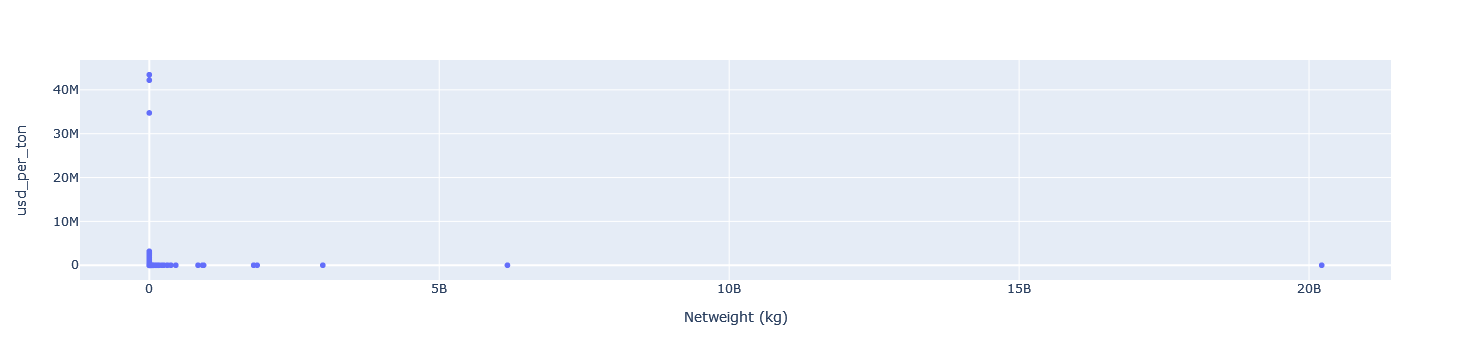

In [16]:
import plotly.express as px
px.scatter(filtered_df, x="Netweight (kg)", y="usd_per_ton", hover_data=['Commodity'])

In [11]:
cond = (~df["Netweight (kg)"].isnull()) & (~df["Trade Value (US$)"].isnull())
filtered_df = df[cond].copy(deep=True)
filtered_df["usd_per_ton"] = filtered_df["Trade Value (US$)"] / (filtered_df["Netweight (kg)"] / 1000)

,Netweight (kg),Trade Value (US$),Commodity Code,Commodity,trigram,usd_per_ton
0,55965.0,1090985,101,"Horses, asses, mules and hinnies; live",GAN,19494.058787
1,220792.0,2335760,102,Bovine animals; live,GAN,10579.006486
2,25602.0,603215,103,Swine; live,GAN,23561.245215
3,165170.0,2928106,104,Sheep and goats; live,GAN,17727.831931
4,263443.0,19037864,105,"Poultry; live, fowls of the species Gallus dom...",GAN,72265.590659
...,...,...,...,...,...,...
2019,361.0,1661,9618,Tailors' dummies and other lay figures; automa...,MAN,4601.108033
2020,4326229.0,14650349,9619,"Sanitary towels (pads) and tampons, napkins an...",MAN,3386.401644
2021,602.0,11126,9701,"Paintings, drawings, pastels, executed entirel...",MAN,18481.727575
2022,866.0,9600,9703,"Sculptures and statuary; original, in any mate...",MAN,11085.450346


In [6]:
input_folder = os.path.join('..', '..', '..', 'Ecuador', 'Data')
trade_data = pd.read_csv(os.path.join(input_folder, "Raw", "Trade", "comtrade_2016_AG4_ImportsExport_EcuadorReport_WolrdPartner.csv"))

df = trade_data[['Netweight (kg)', 'Trade Value (US$)', 'Commodity Code', 'Commodity']].copy()
#df['hs2'] = df['Commodity Code'].astype(str).str.zfill(3).str[:2].astype(int)

#map sectors
H3_to_Sector = pd.read_csv(os.path.join(input_folder, "Structured", "Trade", "HS17lvl4_to_59sectors.csv")).set_index('hs17_lvl4_code')['trigram']
df['trigram'] = df['Commodity Code'].map(H3_to_Sector)

#get result
def aggFct(df):
    kg_col = 'Netweight (kg)'
    usd_col = 'Trade Value (US$)'
    cond = (~df[kg_col].isnull()) & (~df[usd_col].isnull())
    filtered_df = df[cond].copy(deep=True)
    usd_per_ton = filtered_df[usd_col] / (filtered_df[kg_col] / 1000)
    weighted_usd_per_ton = usd_per_ton * filtered_df[kg_col] / filtered_df[kg_col].sum()
    return weighted_usd_per_ton.sum()
res = df.groupby('trigram').apply(aggFct)
res['IMP'] = aggFct(df[df['trigram'] != "ELE"])

res#.to_csv(os.path.join(input_folder, "Structured", "Sectors", "59sector_usd_per_tons.csv"))

trigram
AGU      680.743231
ALD      822.198330
AYG      870.672508
AZU      831.416110
BAL     1298.267257
BNA     3032.433087
CAN     1340.624275
CAR      901.393052
CAU     3483.704493
CEM      217.239559
CER      272.837053
CHO     2404.664941
CIN     2513.549895
CUE     4909.827217
DEM     4218.405831
ELE        0.000000
FID     3651.114766
FRT      446.900961
FRV     2263.524260
GAN    31112.571766
HIL     3187.624698
LAC     3115.139067
MAD      456.972608
MAN     5174.883605
MAQ    11522.423313
MET     1147.052083
MIP      289.685066
MOL      574.686893
MUE     3962.158922
PAN     2135.838403
PAP     1202.909534
PES     2431.393186
PLS     2886.142636
PPR     5559.097267
QU1      821.012349
QU2     5438.605441
TAB    11125.794309
VES    12192.437435
VID      801.678390
IMP      719.885436
dtype: float64

# Produce tech coef - Legacy

In [5]:
techCoef = pd.read_excel(os.path.join(folder, "Data", "Structured", "InputOutputTable", "inputOutputTable.xlsx"), sheet_name="domestic_techCoef")
techCoef = techCoef.iloc[:-1,:]
techCoef.to_csv(os.path.join(folder, "Data", "Structured", "InputOutputTable", "techCoef.csv"))

# Produce country importance as importer

In [88]:
# load data
sectorFromImportSector_techCoef = pd.read_excel(os.path.join(folder, "Data", "Structured", "InputOutputTable", "inputOutputTable.xlsx"), sheet_name="sectorImports_techCoef")
import_per_contry_sector_abs = pd.read_csv(os.path.join(folder, "Data", "Structured", "Trade", "import_table.csv")).set_index("sector_code").transpose()

# get relative importance of each country for each product type (=sector)
import_per_contry_sector_rel = import_per_contry_sector_abs/import_per_contry_sector_abs.sum()

# merge with sector for which no data to get full matrix
import_per_contry_sector_rel = import_per_contry_sector_rel.transpose().reset_index()
import_per_contry_sector_rel = import_per_contry_sector_rel.merge(pd.DataFrame({'sector_code':sectorFromImportSector_techCoef.index.tolist()}), how="right", on="sector_code")

# To fill the sector for which no country elements, we suppose that only Asia, Thailand, Viet Nam (because many services, suppose local, and these 3 represent over 95% anyway)
# And we suppose that it is in the same proportions between the three as for the other sectors
proportion = {}
selected_country = ['C5', 'C1', 'C0']
for country in selected_country:
    proportion[country] = import_per_contry_sector_rel[country].sum() / import_per_contry_sector_rel[selected_country].sum().sum()

boolindex_country_to_treat = import_per_contry_sector_rel.iloc[:,1:].isnull().all(axis=1)
for country in selected_country:
    import_per_contry_sector_rel.loc[boolindex_country_to_treat, country] = proportion[country]

# put the rest to 0
import_per_contry_sector_rel = import_per_contry_sector_rel.fillna(0)

# sort and prepare for matrix operation
import_per_contry_sector_rel = import_per_contry_sector_rel.sort_values('sector_code').set_index('sector_code')

# compute coef tech of country sector, i.e., how much of each domestic sector by from a foreign country to produce one unit of output
countrySector_coefTech = sectorFromImportSector_techCoef.transpose().dot(import_per_contry_sector_rel).transpose()

# this tells the importance of each country as importer for specific sectors
countrySector_importance = countrySector_coefTech / countrySector_coefTech.sum()
countrySector_importance = countrySector_importance.transpose()

# export
countrySector_importance.to_csv(os.path.join(folder, "Data", "Structured", "Trade", "countryImportanceForSector.csv"))

# Transit matrix

In [4]:
# Build matrix
countries = pd.read_csv(os.path.join(input_folder, "Structured", "Trade", "country_table.csv"))['trigram'].tolist()
transit_matrix = pd.DataFrame(index=countries, columns=countries, data=0)
transit_matrix

,COL,PER,CAR,AFR,NAM,SAM,ASI,EUR,OCE
COL,0,0,0,0,0,0,0,0,0
PER,0,0,0,0,0,0,0,0,0
CAR,0,0,0,0,0,0,0,0,0
AFR,0,0,0,0,0,0,0,0,0
NAM,0,0,0,0,0,0,0,0,0
SAM,0,0,0,0,0,0,0,0,0
ASI,0,0,0,0,0,0,0,0,0
EUR,0,0,0,0,0,0,0,0,0
OCE,0,0,0,0,0,0,0,0,0


In [5]:
# We assume PER there are no transit flows, except between Colombia and Peru
# Rationale is PER COL and PER have big ports, they do not need ECU to trade with other countries
# A share of the trade between COL and PER could go via the terrestrial route, as opposed to port to port
# No data on PER, so we assume 10%. Guesstimate.
COL_PER = pd.read_csv(os.path.join(input_folder, "Raw", "Trade", "comtrade_2016_COLPER.csv"))

COL_to_PER = \
    (COL_PER.loc[
        (COL_PER['Trade Flow']=="Export")&\
        (COL_PER['Reporter']=="Colombia")&\
        (COL_PER['Partner']=="Peru")
    ,'Trade Value (US$)'].iloc[0] +
     COL_PER.loc[
        (COL_PER['Trade Flow']=="Import")&\
        (COL_PER['Reporter']=="Peru")&\
        (COL_PER['Partner']=="Colombia")
    ,'Trade Value (US$)'].iloc[0])/2
print("COL_to_PER:", COL_to_PER)

PER_to_COL = \
    (COL_PER.loc[
        (COL_PER['Trade Flow']=="Export")&\
        (COL_PER['Reporter']=="Peru")&\
        (COL_PER['Partner']=="Colombia")
    ,'Trade Value (US$)'].iloc[0] +
     COL_PER.loc[
        (COL_PER['Trade Flow']=="Import")&\
        (COL_PER['Reporter']=="Colombia")&\
        (COL_PER['Partner']=="Peru")
    ,'Trade Value (US$)'].iloc[0])/2
print("PER_to_COL:", PER_to_COL)

COL_to_PER: 1114454513.5
PER_to_COL: 697190200.0


In [6]:
HOW_MUCH_GOES_THROUGH_ECU = 0.1
transit_matrix.loc['COL', 'PER'] = PER_to_COL * HOW_MUCH_GOES_THROUGH_ECU
transit_matrix.loc['PER', 'COL'] = PER_to_COL * HOW_MUCH_GOES_THROUGH_ECU
transit_matrix

,COL,PER,CAR,AFR,NAM,SAM,ASI,EUR,OCE
COL,0,69719020,0,0,0,0,0,0,0
PER,69719020,0,0,0,0,0,0,0,0
CAR,0,0,0,0,0,0,0,0,0
AFR,0,0,0,0,0,0,0,0,0
NAM,0,0,0,0,0,0,0,0,0
SAM,0,0,0,0,0,0,0,0,0
ASI,0,0,0,0,0,0,0,0,0
EUR,0,0,0,0,0,0,0,0,0
OCE,0,0,0,0,0,0,0,0,0


In [7]:
#turn into kUSD
transit_matrix = transit_matrix / 1000

In [8]:
transit_matrix.to_csv(os.path.join(output_folder, "transit_matrix.csv"), index=True)

# Legacy Cambodia

In [28]:
# Build matrix
countries = pd.read_csv(os.path.join(folder, "Data", "Structured", "Trade", "country_table.csv"))['trigram'].tolist()
transit_matrix = pd.DataFrame(index=countries, columns=countries, data=0)
transit_matrix

,VNM,THA,LAO,AFR,AME,ASI,EUR,OCE
VNM,0,0,0,0,0,0,0,0
THA,0,0,0,0,0,0,0,0
LAO,0,0,0,0,0,0,0,0
AFR,0,0,0,0,0,0,0,0
AME,0,0,0,0,0,0,0,0
ASI,0,0,0,0,0,0,0,0
EUR,0,0,0,0,0,0,0,0
OCE,0,0,0,0,0,0,0,0


In [34]:
# We assume that there are no transit flows, except between Viet Nam and Thailand
# Rationale is that VNM and THA have big ports, they do not need KHM to trade with other countries
# There seem to be almost nothing going on at the border between KHM and LAO
# A share of the trade between VNM and THA could go via the KHM terrestrial route, as opposed to port to port
# No data on that, so we assume 10%. Guesstimate.
VMM_THA = pd.read_csv(os.path.join(folder, "Data", "Raw", "Trade", "UNComTrade_ThaiilandVietnam.csv"))

VNM_to_THA = \
    (VMM_THA.loc[
        (VMM_THA['Trade Flow']=="Export")&\
        (VMM_THA['Reporter']=="Viet Nam")&\
        (VMM_THA['Partner']=="Thailand")
    ,'Trade Value (US$)'].iloc[0] +
     VMM_THA.loc[
        (VMM_THA['Trade Flow']=="Import")&\
        (VMM_THA['Reporter']=="Thailand")&\
        (VMM_THA['Partner']=="Viet Nam")
    ,'Trade Value (US$)'].iloc[0])/2
print("VNM_to_THA:", VNM_to_THA)

THA_to_VNM = \
    (VMM_THA.loc[
        (VMM_THA['Trade Flow']=="Export")&\
        (VMM_THA['Reporter']=="Thailand")&\
        (VMM_THA['Partner']=="Viet Nam")
    ,'Trade Value (US$)'].iloc[0] +
     VMM_THA.loc[
        (VMM_THA['Trade Flow']=="Import")&\
        (VMM_THA['Reporter']=="Viet Nam")&\
        (VMM_THA['Partner']=="Thailand")
    ,'Trade Value (US$)'].iloc[0])/2
print("THA_to_VNM:", THA_to_VNM)

VNM_to_THA: 5488260149.5
VNM_to_THA: 12500485144.5


In [37]:
HOW_MUCH_GOES_THROUGH_KHM = 0.1
transit_matrix.loc['VNM', 'THA'] = VNM_to_THA*HOW_MUCH_GOES_THROUGH_KHM
transit_matrix.loc['THA', 'VNM'] = THA_to_VNM*HOW_MUCH_GOES_THROUGH_KHM
transit_matrix

,VNM,THA,LAO,AFR,AME,ASI,EUR,OCE
VNM,0.000000e+00,5.488260e+08,0,0,0,0,0,0
THA,1.250049e+09,0.000000e+00,0,0,0,0,0,0
LAO,0.000000e+00,0.000000e+00,0,0,0,0,0,0
AFR,0.000000e+00,0.000000e+00,0,0,0,0,0,0
AME,0.000000e+00,0.000000e+00,0,0,0,0,0,0
ASI,0.000000e+00,0.000000e+00,0,0,0,0,0,0
EUR,0.000000e+00,0.000000e+00,0,0,0,0,0,0
OCE,0.000000e+00,0.000000e+00,0,0,0,0,0,0


In [38]:
transit_matrix.to_csv(os.path.join(folder, "Data", "Structured", "Trade", "transit_matrix.csv"), index=True)

### Export and import flows for analysis

In [16]:
rename_sec = {
    "CRO": "Agriculture",
    "LIV": "Livestock",
    "FOR": "Forestry & Logging",
    "FIS": "Fishing",
    "MIN": "Mining",
    "MFO": "Man. of Food Prod.",
    "MBE": "Man. of Beverages",
    "MTE": "Man. of Textiles",
    "MRU": "Man. of Rubber & Plastics",
    "ELE": "Utilities",
    "CON": "Construction",
    "TRW": "Wholesale Trade",
    "TRL": "Transport",
    "ACF": "Accomodation & Food Services",
    "TEL": "Telco",
    "FIN": "Financial Services",
    "REA": "Real Estate",
    "TRA": "Travel",
    "ADM": "Administration",
    "EDU": "Education",
    "HEA": "Health",
    "OPS": "Personnal Services",
    "MAO": "Other Man.",
    "MBA": "Man. of Basic Metals",
    "MCH": "Man. of Chemicals",
    "MCO": "Man. of Petroleum Prod.",
    "MEL": "Man. of Eletronics",
    "MFA": "Man. of Metal Prod.",
    "MFU": "Man. of Furniture",
    "MMA": "Man. of Machinery",
    "MPA": "Man. of Paper",
    "MPH": "Man. of Pharmaceuticals",
    "MTO": "Man. of Tobacco Prod.",
    "MTR": "Man. of Transport Eq.",
    "MWO": "Man. of Wood Prod.",
    "MNM": "Man. of Mineral Prod."
}
rename_country = {
    'AFR': "Africa",
    "AME": "America",
    "ASI": "Asia",
    "EUR": "Europe",
    "OCE": "Oceania",
    "THA": "Thailand",
    "VNM": "Viet Nam",
    "LAO": "Laos"
}

def renameCol(df, what, mapping):
    df[what+'_name'] = df[what].map(mapping)
    if df[what+'_name'].isnull().sum()>0:
        print("Unmapped values")
        print(df[df[what+'_name'].isnull()])
    return df

In [18]:
df = pd.read_csv(os.path.join(folder, "Data", "Structured", "Trade", "import_table.csv"), index_col=0)
df = df.unstack().reset_index()
df.columns = ['buying_sector', 'supplying_country', 'flow']
df = df[df['flow']>1000000]
df = renameCol(df, 'buying_sector', rename_sec)
df = renameCol(df, 'supplying_country', rename_country)
df.to_csv(os.path.join(folder, "Data", "Structured", "Trade", 'import_flows.csv'), index=False)

In [21]:
df = pd.read_csv(os.path.join(folder, "Data", "Structured", "Trade", "export_table.csv"), index_col=0)
df = df.unstack().reset_index()
df.columns = ['supplying_sector', 'buying_country', 'flow']
df = df[df['flow']>1000000]
df = renameCol(df, 'supplying_sector', rename_sec)
df = renameCol(df, 'buying_country', rename_country)
df.to_csv(os.path.join(folder, "Data", "Structured", "Trade", 'export_flows.csv'), index=False)

# Test

In [10]:
ref = pd.read_csv('ref_cmd_HS.csv').set_index('id')
ref.loc['1001']
#ref.loc[ref['standardUnitAbbr'] == 'kg']

text                1001 - Wheat and meslin
parent                                   10
isLeaf                                    0
aggrLevel                                 4
standardUnitAbbr                        NaN
Name: 1001, dtype: object

In [33]:
ref.loc['1009']

KeyError: '1009'

In [35]:
ref[ref['text'].str.contains('vegetable', case=False)]

,text,parent,isLeaf,aggrLevel,standardUnitAbbr
id,,,,,
07,07 - Vegetables and certain roots and tubers; ...,TOTAL,0,2,NaN
070110,"070110 - Vegetables; seed potatoes, fresh or c...",0701,1,6,kg
070190,070190 - Vegetables; potatoes (other than seed...,0701,1,6,kg
070200,"070200 - Vegetables; tomatoes, fresh or chilled",0702,1,6,kg
0703,"0703 - Onions, shallots, garlic, leeks and oth...",07,0,4,NaN
...,...,...,...,...,...
847920,847920 - Machinery; for the extraction or prep...,8479,1,6,u
850940,850940 - Electro-mechanical domestic appliance...,8509,1,6,u
9602,"9602 - Vegetable, mineral carving material and...",96,0,4,NaN


In [2]:
gsc_cpc = pd.read_csv('GSC-CPC21.csv', dtype={"Code_Num": str})
gsc_cpc = gsc_cpc.rename(columns={'Code': 'gsc', 'Code_Num': 'cpc'})
gsc_cpc.head()

,Number,gsc,cpc,Description
0,1,pdr,0113,Rice
1,2,wht,0111,Wheat
2,3,gro,0112,Maize (corn)
3,3,gro,0114,Sorghum
4,3,gro,0115,Barley


In [3]:
gsc_isic = pd.read_csv('GSC-ISIC4.csv', dtype={"Code_Num": str})
gsc_isic = gsc_isic.rename(columns={'Code': 'gsc', 'Code_Num': 'isic'})
gsc_isic.head()

,Number,gsc,isic,Description
0,14,fsh,03,Fishing and aquaculture
1,14,fsh,017,"Hunting, trapping and related service activities"
2,15,coa,05,Mining of coal and lignite
3,16,oil,061,Extraction of crude petroleum
4,16,oil,091,Support activities for petroleum and natural g...


In [4]:
ref_cpc_hs = pd.read_csv('CPC21-HS2017.csv', dtype={"HS 2017": str, "CPC Ver. 2.1": str})
ref_cpc_hs['HS 2017'] = ref_cpc_hs['HS 2017'].str.replace('.', '')
ref_cpc_hs = ref_cpc_hs.rename(columns={'HS 2017': 'hs', 'CPC Ver. 2.1': 'cpc'})
ref_cpc_hs.head()

,hs,HS partial,cpc,CPC partial
0,010121,0,02131,1
1,010129,0,02131,1
2,010130,0,02132,0
3,010190,0,02133,0
4,010221,0,02111,1


In [5]:
ref_cpc_isic = pd.read_csv('ISIC4-CPC21.csv', dtype={"ISIC4code": str, "CPC21code": str})
ref_cpc_isic = ref_cpc_isic.rename(columns={'ISIC4code': 'isic', 'CPC21code': 'cpc'})
ref_cpc_isic.head()

,isic,ISIC4partial,cpc,CPC21partial
0,0111,1,01111,0
1,0111,1,01112,0
2,0111,1,01121,0
3,0111,1,01122,0
4,0111,1,01141,0


In [125]:
gsc_isic.groupby('gsc')['isic'].apply(list)

gsc
bph                [21]
chm                [20]
cns        [41, 42, 43]
coa                [05]
eeq                [27]
ele                [26]
ely          [351, 353]
fmp                [25]
fsh           [03, 017]
gas          [062, 091]
gdt               [352]
i_s         [241, 2431]
lea                [15]
lum                [16]
mvh                [29]
nfm         [242, 2432]
nmm                [23]
oil          [061, 091]
ome                [28]
omf        [31, 32, 33]
otn                [30]
oxt       [07, 08, 099]
p_c                [19]
ppp            [17, 18]
rpp                [22]
tex                [13]
wap                [14]
wtr    [36, 37, 38, 39]
Name: isic, dtype: object

In [12]:
from tqdm import tqdm

def map_isic_to_cpc_codes(isic_code, ref):
    matching_lines = ref['isic'].str[:len(isic_code)] == isic_code
    return list(ref.loc[matching_lines, "cpc"].unique())
    
def map_cpc_to_hs_codes(cpc_code, ref):
    matching_lines = ref['cpc'].str[:len(cpc_code)] == cpc_code
    return list(ref.loc[matching_lines, "hs"].unique())

res1 = gsc_cpc.groupby('gsc')['cpc'].apply(list)

for gsc, cpcs in tqdm(res1.items(), total=len(res1)):
    hs_codes_list = [map_cpc_to_hs_codes(cpc, ref_cpc_hs) for cpc in cpcs]
    res1[gsc] = [item for sublist in hs_codes_list for item in sublist]


res2 = gsc_isic.groupby('gsc')['isic'].apply(list)
for gsc, isics in tqdm(res2.items(), total=len(res2)):
    cpc_code_list = [map_isic_to_cpc_codes(isic, ref_cpc_isic) for isic in isics]
    cpc_code_list = [item for sublist in cpc_code_list for item in sublist]
    hs_codes = [map_cpc_to_hs_codes(cpc_code, ref_cpc_hs) for cpc_code in cpc_code_list]
    res2[gsc] = [item for sublist in hs_codes for item in sublist]

res = {**res1, **res2}

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.34it/s]


In [8]:
str(res)[:1000]

"{'b_t': ['110710', '110720', '220110', '220190', '220210', '220291', '220299', '220300', '220410', '220421', '220422', '220429', '220430', '220510', '220590', '220600', '220710', '220820', '220830', '220840', '220850', '220860', '220870', '220890', '240120', '240210', '240220', '240290', '240311', '240319', '240391', '240399'], 'c_b': ['120910', '121291', '121293', '121299'], 'cmt': ['020110', '020120', '020130', '020110', '020120', '020130', '020410', '020421', '020422', '020423', '020450', '020860', '020500', '020830', '020840', '020890', '020210', '020220', '020230', '020321', '020322', '020329', '020430', '020441', '020442', '020443', '020450', '020500', '020810', '020830', '020840', '020860', '020890', '020610', '020621', '020622', '020629', '020630', '020641', '020649', '020680', '020690', '020810', '020830', '020840', '020860', '020890', '050400'], 'ctl': ['010221', '010229', '010231', '010239', '010290', '010410', '010420', '010613', '010619', '010121', '010129', '010130', '01

In [6]:
import requests

url = "https://comtradeapi.un.org/files/v1/app/reference/HS.json"
response = requests.get(url)
response.raise_for_status()  # Raise an error for bad responses (4xx and 5xx)
ref_hs = response.json()
ref_hs = pd.DataFrame(ref_hs['results'])
ref_hs.head()

,id,text,parent,isLeaf,aggrLevel,standardUnitAbbr
0,TOTAL,Total - All H6 commodities,#,0,0,n/a
1,01,01 - Animals; live,TOTAL,0,2,n/a
2,0101,"0101 - Horses, asses, mules and hinnies; live",01,0,4,n/a
3,010110,010110 - - Pure-bred breeding animals,0101,1,6,u
4,010111,010111 - Horses :-- Pure-bred breeding animals,0101,1,6,u


In [10]:
hs_4digits_to_6digits = ref_hs[ref_hs['aggrLevel'] == 6].groupby('parent')['id'].apply(list).to_dict()

In [147]:
hs_4digits_to_6digits['0201']

False

In [20]:
# if all the 6-digit codes of one 4-digit category are present, replace all the 6-digit codes by the 4-digit code
k = 0

#new_res = {}
for gsc, hs_list in tqdm(res.items()):
    #print(gsc)
    for hs_4d, hs_6d_list in hs_4digits_to_6digits.items():
        if set(hs_6d_list).issubset(set(hs_list)):
            #print(hs_4d, hs_6d_list)
            new_list = set(hs_list) - set(hs_6d_list)
            hs_list = list(new_list | set([hs_4d]))
            #print(hs_list)
            #print(len(hs_list))
    res[gsc] = hs_list
    k += 1
    #if k == 1:
    #    break

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 173.47it/s]


In [154]:
the_list = res['wap']
print(len(the_list))
str(the_list).replace("'", "").replace("[", "").replace("]", "").replace(" ", "")

153


'6210,621112,610343,610729,620332,610323,610791,620333,611120,620930,620323,610342,610711,611529,610432,620799,650699,611510,610459,610120,620530,620219,620112,620341,610712,621111,610349,610449,6504,610442,620211,621320,610413,620342,610721,6109,6204,610462,611780,610461,4304,610469,650500,611130,620119,620199,611710,611190,620520,611790,620711,620291,610452,610722,620311,621142,610463,610419,610333,620349,620920,610433,611521,620293,610341,610429,611596,620193,420330,611090,620113,392620,620322,610423,610451,620590,6106,6507,6212,6216,620719,420329,620329,620213,611011,620319,6108,621139,6502,610799,610443,611522,620299,611594,620722,620331,610444,611012,611595,620339,611019,610719,620990,610190,6112,610322,621133,6501,610339,610329,611420,620729,621120,6116,6208,610331,621143,620312,610441,620212,6113,610332,611430,611490,621132,420340,620111,620191,621149,6206,420310,620292,6217,620791,611030,610439,6214,620343,4303,620721,621390,611530,6215,610453,6102,610310,611599,611020,610431,

In [128]:
len(res)

50

In [161]:
from pathlib import Path

# Define the directory path
directory = Path(os.path.join('..', '..', 'disruptsc-dataprep', 'dataprep', 'data'))

dfs = []
# Iterate over files in the directory
for file in directory.iterdir():
    if file.is_file():  # Ensure it's a file
        name_without_ext = file.stem
        print(name_without_ext)
        df = pd.read_csv(file, index_col=False)
        gsc_nb, gsc_name = name_without_ext.split('-')
        df['gsc_nb'] = gsc_nb
        df['gsc'] = gsc_name
        dfs.append(df)

df = pd.concat(dfs)
df = df[df['qtyUnitAbbr'] == 'kg']
df['gsc'] = df['gsc'].str[:3]
df.head()

1-pdr
10-oap
11-rmk
12-wol
13-frs
14-fsh
15-coa
16-oil
17-gas
18-oxt
19-cmt
2-wht
20-omt
21-vol
22-mil
23-pcr
24-sgr
25-ofd+1
25-ofd+2
26-b_t
27-tex+1
27-tex+2
28-wap
29-lea
3-gro
30-lum
31-ppp
32-p_c
33-chm+1
33-chm+2
33-chm+3
33-chm+4
34-bph
35-rpp
36-nmm
37-i_s
38-nfm
39-fmp
4-v_f
40-ele
41-eeq
42-ome+1
42-ome+2
43-mvh
44-otn
45-omf
5-osd
6-c_b
7-pfb
8-ocr
9-ctl


,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate,gsc_nb,gsc
0,C,A,20230101,2023,52,2023,398,KAZ,Kazakhstan,X,...,0,False,NaN,1684980.42,1684980.42,0,False,True,1,pdr
10,C,A,20230101,2023,52,2023,398,KAZ,Kazakhstan,X,...,0,False,NaN,9012543.46,9012543.46,0,False,True,10,oap
11,C,A,20230101,2023,52,2023,398,KAZ,Kazakhstan,X,...,0,False,NaN,869284.00,869284.00,0,False,True,10,oap
13,C,A,20230101,2023,52,2023,398,KAZ,Kazakhstan,X,...,0,False,NaN,2533007.04,2533007.04,0,False,True,10,oap
14,C,A,20230101,2023,52,2023,398,KAZ,Kazakhstan,X,...,0,False,NaN,520.00,520.00,0,False,True,10,oap


In [162]:
def calulate_mean_usd_per_ton(df):
    usd = df['primaryValue'].sum()
    ton = df['qty'].sum() / 1000
    return usd / ton

usd_per_ton = df.groupby(['gsc_nb', 'gsc']).apply(calulate_mean_usd_per_ton, include_groups=False)
usd_per_ton = df.groupby('gsc').apply(calulate_mean_usd_per_ton, include_groups=False).to_dict()
mean_usd_per_ton = calulate_mean_usd_per_ton(df)
print(mean_usd_per_ton)

471.75666274587684


In [164]:
sector_table_filepath = os.path.join('..', 'input', 'ECA', 'Network', 'sector_table.csv')
sector_table = pd.read_csv(sector_table_filepath, index_col=0)
sector_table['usd_per_ton'] = sector_table['sector_code'].str.lower().map(usd_per_ton)
print(sector_table.loc[sector_table['usd_per_ton'].isnull(), 'type'].value_counts())
sector_table.loc[sector_table['usd_per_ton'].isnull() & (sector_table['type'] == 'imports'), "usd_per_ton"] = mean_usd_per_ton
sector_table.loc[sector_table['usd_per_ton'].isnull(), 'usd_per_ton'] = 0.0
print(sector_table.loc[sector_table['usd_per_ton'].isnull(), 'type'].value_counts())

sector_table.to_csv(sector_table_filepath, index=False)

type
service      252
transport     54
utility       54
imports        1
Name: count, dtype: int64
Series([], Name: count, dtype: int64)


In [68]:
df.loc[(df['qtyUnitAbbr'] != 'kg'), ['cmdDesc', 'qtyUnitAbbr']]

,cmdDesc,qtyUnitAbbr
0,"Bulbs, tubers, tuberous roots, corms, crowns a...",u
1,"Plants, live; unrooted cuttings and slips",u
2,"Plants, live; edible fruit or nut trees, shrub...",u
3,"Plants, live; rhododendrons and azaleas, graft...",u
4,"Plants, live; roses, grafted or not",u
25,"Vegetables; onions, whole, cut, sliced, broken...",NaN
43,"Spices; coriander seeds, crushed or ground",NaN
94,Vinegar and substitutes for vinegar obtained f...,l
55,"Sugars; fructose, chemically pure, in solid form",NaN
60,Pasta; whether or not cooked or stuffed with m...,NaN
